In [14]:
import os
import locale
locale.setlocale(locale.LC_ALL, 'en_US')
import numpy as np
import pandas as pd
import pandas_ta as pta
from ta.volatility import BollingerBands
import matplotlib.pyplot as plt

In [15]:
def calculate_tis(df):

    # EMAs
    df['ema200'] = pta.ema(close=df['close'], length=200)
    df['ema50'] = pta.ema(close=df['close'], length=50)

    #  RSI
    df['rsi'] = pta.rsi(close=df['close'], window=14)

    #  Bollinger Bands
    indicator_bb = BollingerBands(close=df['close'], window=20, window_dev=2)
    df['bb_low'] = indicator_bb.bollinger_lband()
    df['bb_high'] = indicator_bb.bollinger_hband()

    #  Reorder columns
    df = df[['open', 'high', 'low', 'close', 'volume', 'ema200', 'ema50', 'rsi', 'bb_low', 'bb_high']]

    #  Drop the first 200 periods which we needed for EMA 200 calculation
    df = df.tail(len(df) - 200)
    df.dropna(inplace=True)

    return df

In [16]:
def train_test_split(data_array, rows, train_percent):
    
    display_len_train_records = int(rows * train_percent)
    train_data = data_array[0: display_len_train_records]
    test_data = data_array[display_len_train_records:]

    return train_data, test_data

In [17]:
from sklearn.preprocessing import MinMaxScaler

def scale_data(train_data, test_data):
    
    full_scaler = MinMaxScaler(feature_range=(0, 1))
    full_df = np.concatenate((train_data, test_data), axis=0)
    full_scaler.fit(full_df)
    scaled_full_data = full_scaler.transform(full_df)
    final_scaler = MinMaxScaler(feature_range=(0, 1))
    final_scaler.fit(full_df[:,3].reshape(-1, 1))

    train_scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaler.fit(train_data)
    scaled_train_data = train_scaler.transform(train_data)

    test_scaler = MinMaxScaler(feature_range=(0, 1))
    test_scaler.fit(train_data)
    scaled_test_data = test_scaler.transform(test_data)

    return scaled_full_data, scaled_train_data, scaled_test_data, final_scaler, train_scaler, test_scaler

In [18]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.callbacks import EarlyStopping

def build_model(time_steps, forecast_steps, n_features):
    
    input_shape = (time_steps, n_features)

    model = Sequential()
    model.add(LSTM(units=800, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(LSTM(units=400, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=100))
    model.add(Dropout(0.5))
    model.add(Dense(forecast_steps))

    return model

In [19]:
def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size, patience):
    
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, mode='auto')
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError(name='MSE')])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stop])

    return history

In [20]:
def create_X_ys(X_scaled, time_steps, forecast_steps):
    
    X = []
    y = []
    for i in range(time_steps, X_scaled.shape[0] - forecast_steps + 1):
        X.append(X_scaled[i - time_steps:i])
        y.append(X_scaled[i:i + forecast_steps,3])
    
    X = np.array(X)
    y = np.array(y)

    return X, y

In [21]:
def create_X(X_scaled, time_steps):
    
    X = []
    for i in range(time_steps, X_scaled.shape[0] + 1):
        X.append(X_scaled[i - time_steps:i])

    X = np.array(X)

    return X

In [22]:
def create_predictions(model, X_full, batch_size):

    full_pred_y = model.predict(X_full, batch_size=batch_size)
    
    return full_pred_y

In [23]:
#  Configuration
file_name = 'ETH-USD_1m_ohlc.csv'
interval = '1min'
train_percent = 0.8
epochs = 300
batch_size = 128
time_steps = 20
forecast_steps = 4
patience = 10

In [24]:
#  Load data file
if os.path.exists(file_name):
    df = pd.read_csv(file_name)
    print("Data File Loaded...")
else:
    print("Load Data File Failed...")

#  Calculate technical indicators
df = calculate_tis(df)

#  Get dimensions
rows = df.shape[0]
columns = df.shape[1]

#  Convert df to ndarray
data_array = df.values

#  Split train & test data
train_data, test_data = train_test_split(data_array, rows, train_percent)

#  Scale data
scaled_full_data, scaled_train_data, scaled_test_data, full_scaler, train_scaler, test_scaler = scale_data(train_data, test_data)
n_features = columns

#  Create X_train, y_train, X_test, y_test
X_train, y_train = create_X_ys(scaled_train_data, time_steps, forecast_steps)
X_test, y_test = create_X_ys(scaled_test_data, time_steps, forecast_steps)
X_full = create_X(scaled_full_data, time_steps)

#  Build model
model = build_model(time_steps, forecast_steps, n_features)
print(model.summary())

#  Train model
print("Training Model...")
train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size, patience)

#  Save Model
model.save("tf_forecaster.h5")

Data File Loaded...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 800)           2595200   
                                                                 
 dropout_4 (Dropout)         (None, 20, 800)           0         
                                                                 
 lstm_5 (LSTM)               (None, 20, 400)           1921600   
                                                                 
 dropout_5 (Dropout)         (None, 20, 400)           0         
                                                                 
 lstm_6 (LSTM)               (None, 20, 200)           480800    
                                                                 
 dropout_6 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_7 (LSTM)               (None

Evaluating Model...
2021/2021 [==============================] - 19s 9ms/step


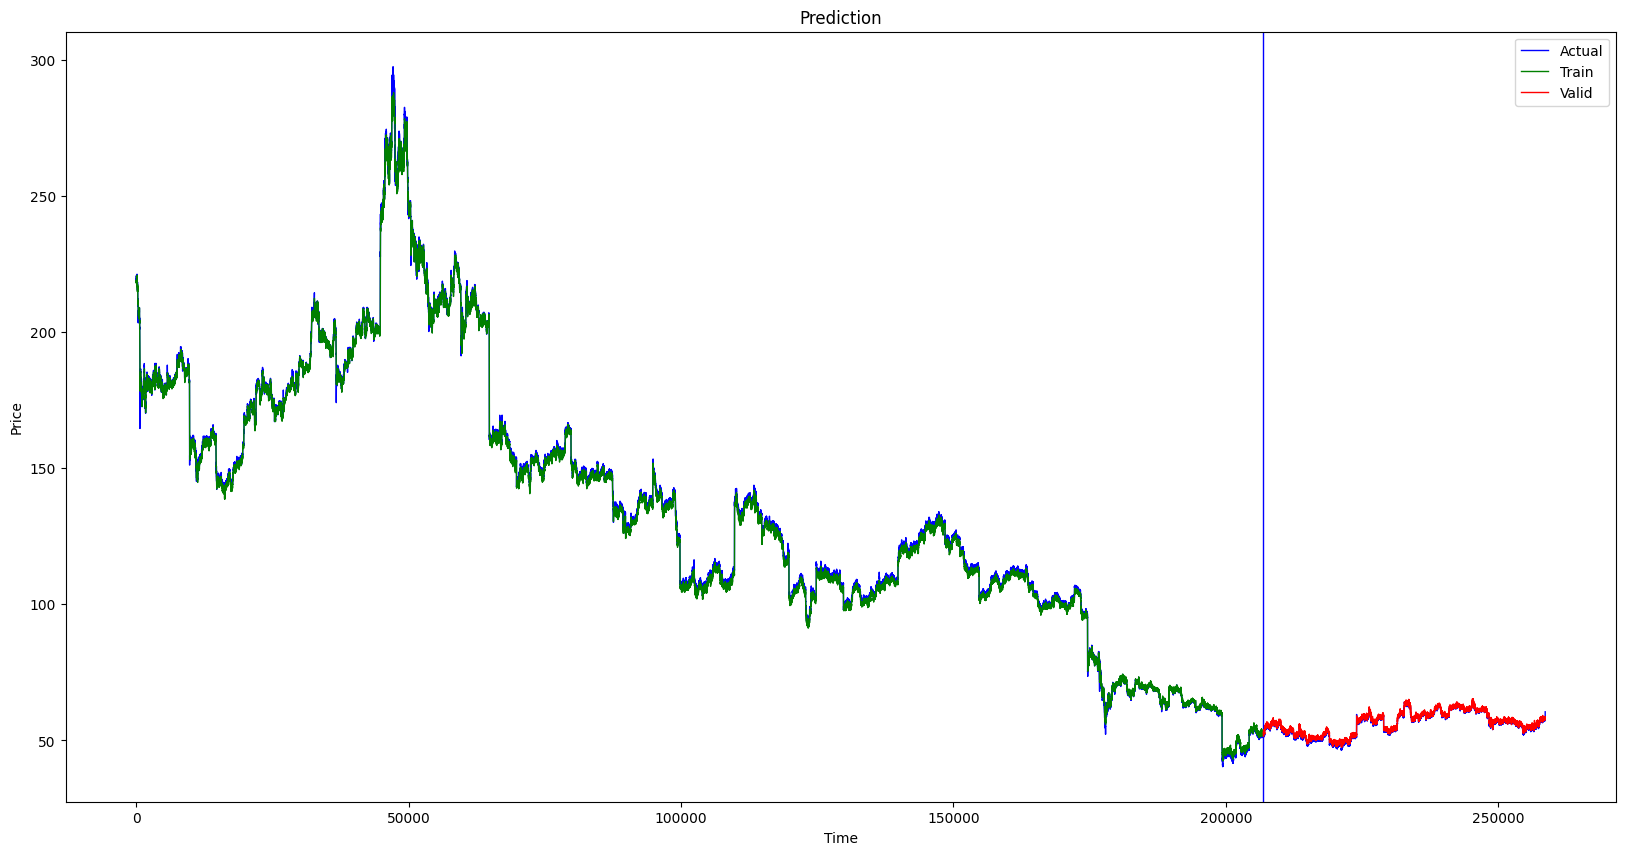

In [25]:
#  Create prediction
print("Evaluating Model...")
full_pred_y = create_predictions(model, X_full, batch_size)

full_real_y_norm = np.concatenate((train_data, test_data), axis=0)
full_real_y_norm = full_real_y_norm[:,3]

train_len = len(train_data)
test_len = len(test_data)
real_len = len(full_real_y_norm)
pred_len = len(full_pred_y)

#  Plot train/test data and prediction result
plt.figure(figsize=(20, 10))
plt.axvline(x=int(real_len*train_percent), color='b', linewidth=1)
plt.plot(full_real_y_norm, color='blue', label='Actual', linewidth=1)

full_pred_y_norm = full_scaler.inverse_transform(full_pred_y[:,0].reshape(-1, 1))
full_pred_y_norm = pd.DataFrame(full_pred_y_norm)
full_pred_y_norm.index += time_steps - 1

plt.plot(range(time_steps, train_len+1), full_pred_y_norm[:train_len-time_steps+1], color='green', label='Train', linewidth=1)
plt.plot(range(train_len,len(full_real_y_norm)), full_pred_y_norm[train_len-time_steps:-1], color='red', label='Valid', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('Prediction')

plt.show()

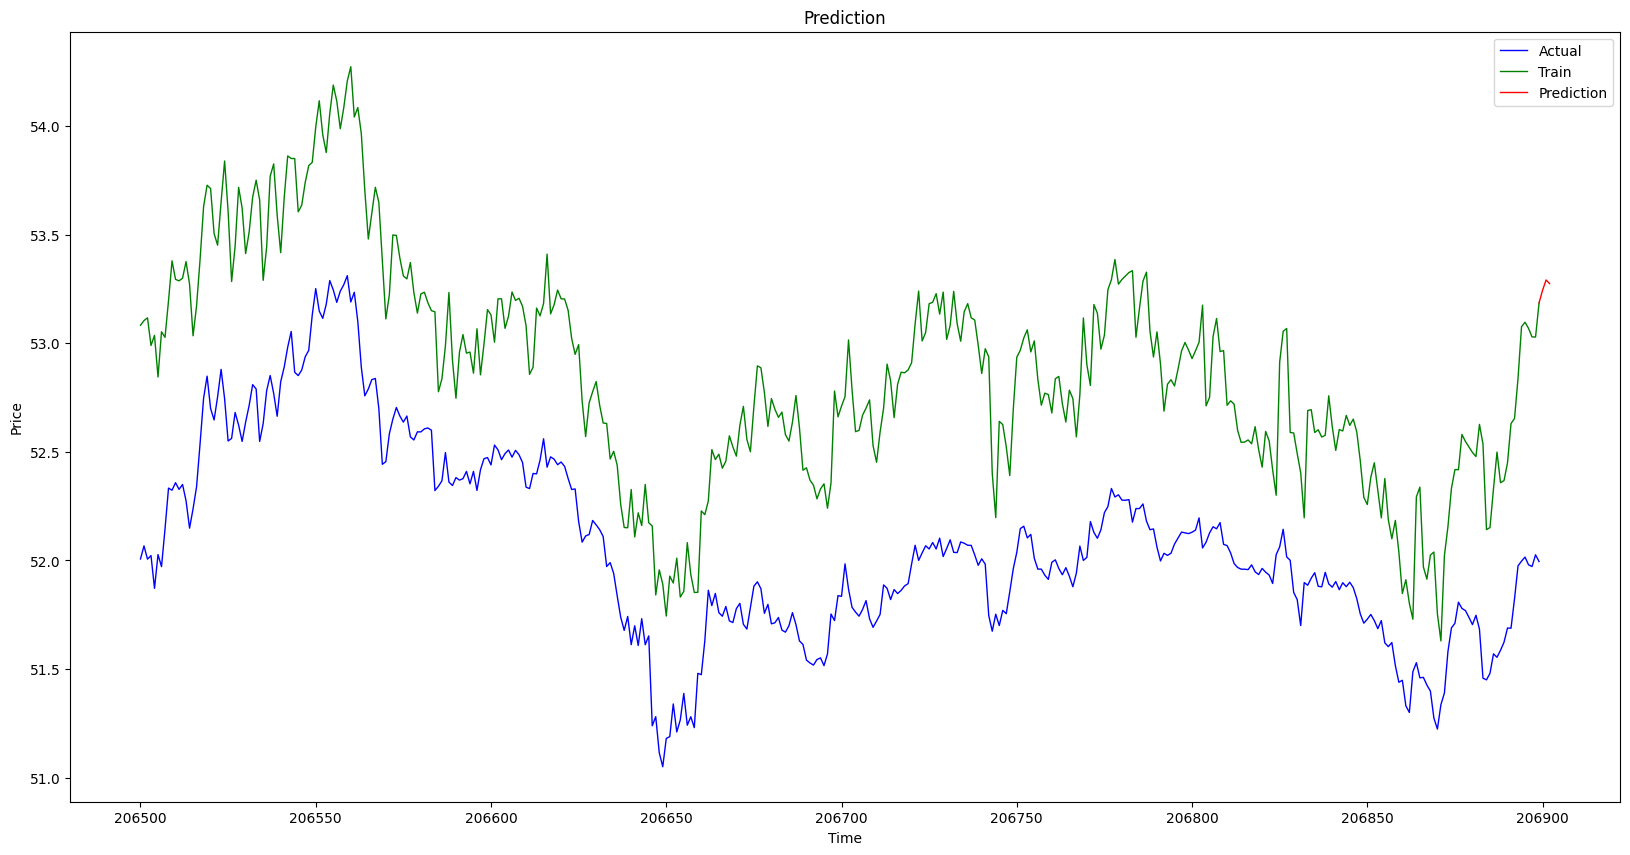

In [26]:
display_len = 400
x_range = range(train_len-display_len, train_len)
x_pred_range = range(train_len-display_len-time_steps, train_len-time_steps)

future_df = []
for i in range(forecast_steps):
    full_pred_y_norm = full_scaler.inverse_transform(full_pred_y[:,i].reshape(-1, 1))
    future_df.append(full_pred_y_norm[train_len-time_steps-1])

#  Plot train/test data and prediction result
plt.figure(figsize=(20, 10))
plt.plot(x_range, full_real_y_norm[x_range], color='blue', label='Actual', linewidth=1)
full_pred_y_norm = full_scaler.inverse_transform(full_pred_y[:,0].reshape(-1, 1))
plt.plot(x_range, full_pred_y_norm[x_pred_range], color='green', label='Train', linewidth=1)
plt.plot(range(len(train_data)-1,len(train_data)+3), future_df, color='red', label='Prediction', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('Prediction')
plt.show()